In [18]:
import sys
sys.path.append("..")

from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from ssl_agent.ssl_agent import SSLAgent
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils
import torch
torch.cuda.empty_cache()

ABX_NB_SAMPLES = 500
AGENT_ABX_DISTANCES = [
    { 
        "art_estimated": {
            "metric": "cosine",
            "weight": 1,
        }
    },
    {   
        "feat_seq": {
            "metric": "cosine",
            "weight": 1,
        }
    }
]

def compute_ABX(agent_path):
    print(agent_path)
    save_path = agent_path / 'results' / 'test_ABX_pb2009.csv'
    save_path.parent.mkdir(exist_ok=True)
    if not save_path.is_file():
        agent = SSLAgent.reload(str(agent_path))
    
        main_dataset = agent.get_main_dataset()
        agent_lab = agent.get_datasplit_lab(2)
    
        consonants = main_dataset.phones_infos["consonants"]
        vowels = main_dataset.phones_infos["vowels"]
        consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
        out = {}
        for distance in AGENT_ABX_DISTANCES:
            agent_features = agent.repeat_datasplit(2)
            abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES, seed=0)
            groups_score = abx_utils.get_groups_score(consonants, abx_matrix, main_dataset.phones_infos["consonant_groups"])
            global_score = abx_utils.get_global_score(abx_matrix)
            distance_name = list(distance.keys())[0]
            scores = {f'place_{distance_name}': groups_score['place'], 
                      f'manner_{distance_name}': groups_score['manner'], 
                      f'global_{distance_name}': global_score}
            out = {**out, **scores}
        out = pd.DataFrame.from_dict([out])
        out.to_csv(save_path, index=False)
    else:
        print("Already done")
    
agent_folder = Path('../out/ssl_agent/cosine/pb2009')


# Compute cosine agents (MFCC and wav2vec 2.0)
for seed in range(0, 5):
    compute_ABX(agent_folder / f'mfcc_delta_delta2_cosine_seed_{seed}')
    for i in range(0, 13):
        agent_name = f'test_layer_{i}_cosine_seed_{seed}'
        agent_path = agent_folder / agent_name
        compute_ABX(agent_path)

# Load MFCC agent
baseline_cosine = {'mfcc_agent': {}}
for seed in range(0, 5):
    agent_name = f'mfcc_delta_delta2_cosine_seed_{seed}'
    agent_path = agent_folder / agent_name / 'results' / 'test_ABX_pb2009.csv'
    res = pd.read_csv(agent_path).to_dict('list')
    res = {k:v[0] for k, v in res.items()}
    for k, v in res.items():
        if k in baseline_cosine['mfcc_agent']:
            baseline_cosine['mfcc_agent'][k].append(v)
        else:
            baseline_cosine['mfcc_agent'][k] = [v]
print(baseline_cosine)

# Load wav2vec 2.0 agent
w2v_cosine = {f'ssl_agent_layer_{i}':{} for i in range(0,13)}
for seed in range(0, 5):
    for i in range(0, 13):
        agent_name = f'test_layer_{i}_cosine_seed_{seed}'
        agent_path = agent_folder / agent_name / 'results' / 'test_ABX_pb2009.csv'
        res = pd.read_csv(agent_path).to_dict('list')
        res = {k:v[0] for k, v in res.items()}
        for k, v in res.items():
            if k in w2v_cosine[f'ssl_agent_layer_{i}']:
                w2v_cosine[f'ssl_agent_layer_{i}'][k].append(v)
            else:
                w2v_cosine[f'ssl_agent_layer_{i}'][k] = [v]     

../out/ssl_agent/cosine/mfcc_delta_delta2_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_0_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_1_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_2_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_3_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_4_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_5_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_6_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_7_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_8_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_9_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_10_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_11_cosine_seed_0
Already done
../out/ssl_agent/cosine/test_layer_12_cosine_seed_0
Already done
../out/ssl_agent/cosine/mfcc_delta_delta2_cosine_seed_1
Already done
../out/ssl_agent/cosine/tes

In [7]:
# Can skip this
# Should be computed on different seeds at some point

distances = [
    {
        "art_real": {
            "metric": "cosine",
            "weight": 1,
            }
    },
    {   
        "feat_seq": {
            "metric": "cosine",
            "weight": 1,
            }
    }
]

gold_abx = {'place_art': [],
            'manner_art': [],
            'global_art': [],
            'place_mfcc': [],
            'manner_mfcc': [],
            'global_mfcc': []}

for seed in range(0, 5):
    agent_file = agent_folder / f'mfcc_delta_delta2_cosine_seed_{seed}'
    agent = SSLAgent.reload(str(agent_file))
    main_dataset = agent.get_main_dataset()
    agent_lab = agent.get_datasplit_lab(2)
    agent_features = agent.repeat_datasplit(2)
    
    real_features = main_dataset.get_items_modality_data('art_params', cut_silences=False, format='.npy')
    real_features = {'pb2009': {'art_real': {k:agent.synthesizer.art_scaler.transform(v) for k,v in real_features.items()},
                               'feat_seq': agent_features['pb2009']['feat_seq']}}
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    
    
    for distance in distances:
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, real_features, distance, ABX_NB_SAMPLES, seed=43)
        groups_score = abx_utils.get_groups_score(consonants, abx_matrix, main_dataset.phones_infos["consonant_groups"])
        global_score = abx_utils.get_global_score(abx_matrix)
        distance_name = list(distance.keys())[0]
        if distance_name == 'art_real':
            key = 'art'
        elif distance_name == 'feat_seq': 
            key = 'mfcc'
        else:
            key =  None
        gold_abx[f'manner_{key}'].append(groups_score['manner'])
        gold_abx[f'place_{key}'].append(groups_score['place'])
        gold_abx[f'global_{key}'].append(global_score)

Removing weight norm...
Transposing features to get [T,N] vectors.
Removing weight norm...
Transposing features to get [T,N] vectors.
Removing weight norm...
Transposing features to get [T,N] vectors.
Removing weight norm...
Transposing features to get [T,N] vectors.
Removing weight norm...
Transposing features to get [T,N] vectors.


NameError: name 'gold_art_abx_manner' is not defined

In [41]:
# Compute ABX on real articulatory trajectories
gold_abx = {
    'gold': {
        'place_art': [94.80833333333332, 94.73333333333332, 95.525, 93.65, 95.05], 
        'manner_art': [66.49666666666666, 66.48333333333333, 66.21666666666667, 66.12666666666667, 64.72333333333333], 
        'global_art': [85.60409356725145, 87.65497076023392, 87.56666666666668, 85.5923976608187, 87.59005847953216], 
        'place_mfcc': [68.34166666666667, 66.84166666666667, 67.20833333333334, 67.93333333333332, 68.74166666666667], 
        'manner_mfcc': [84.6, 84.71666666666667, 85.11999999999999, 85.49666666666666, 85.51333333333334], 
        'global_mfcc': [83.59883040935672, 85.85087719298245, 85.4251461988304, 84.74444444444444, 85.8140350877193]
    }
}

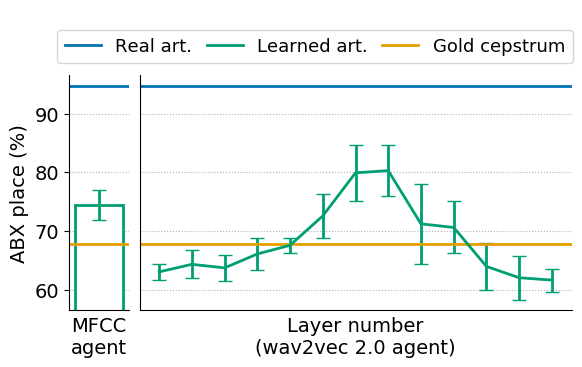

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
import math
import pandas as pd

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 14, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':2, 'errorbar.capsize': 5})

cepstrum_color = '#E69F00'
real_art_color = '#0072B2'
learned_art_color = '#009E73'

cm = 1/2.54
# Plot ABX place
fig = plt.figure(figsize=(14.5*cm,9.04*cm), constrained_layout=True)
gs = gridspec.GridSpec(2, 5, figure=fig, height_ratios=[1,10])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1:])
ax_legend = fig.add_subplot(gs[0, :])
ax_legend.axis('off')

# 1. (MFCC agent) Learned articulatory trajectories
key = 'place_art_estimated'
Y = np.mean(baseline_cosine['mfcc_agent'][key])
Yerr = np.std(baseline_cosine['mfcc_agent'][key], ddof=1)
X = [0.5]
ax1.bar(X, Y, yerr=Yerr, linewidth=2, color='white', ecolor=learned_art_color, edgecolor=learned_art_color)

# 2. (MFCC agent) Real articulatory trajectories
key = 'place_art'
Y = np.mean(gold_abx['gold'][key])
ax1.axhline(Y, color=real_art_color)

# 3. (MFCC agent) MFCCs
key = 'place_mfcc'
Y = np.mean(gold_abx['gold'][key])
ax1.axhline(Y, color=cepstrum_color)

# 1. (wav2vec 2.0 agent) Learned articulatory trajectories
key = 'place_art_estimated'
Y = [np.mean(w2v_cosine[f'ssl_agent_layer_{i}'][key]) for i in range(0,13)]
Yerr = [np.std(w2v_cosine[f'ssl_agent_layer_{i}'][key], ddof=1) for i in range(0,13)]
X = range(0, len(Y))
ax2.errorbar(X, Y, yerr=Yerr, color=learned_art_color)
ax2.set_xticks(X)

# 2. (wav2vec 2.0 agent) Real articulatory trajectories
key = 'place_art'
Y = np.mean(gold_abx['gold'][key])
ax2.axhline(Y, color=real_art_color)

# 3. (wav2vec 2.0 agent) MFCCs
key = 'place_mfcc'
Y = np.mean(gold_abx['gold'][key])
ax2.axhline(Y, color=cepstrum_color)
ax2.set_xticks([])

# Fashion
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(visible=True, axis='y', linestyle=':', zorder=0)
ax2.grid(visible=True, axis='y', linestyle=':', zorder=0)

ax1.set_xticks([])
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
ax1.set_ylim(ax2.get_ylim())
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax1.set_ylabel('ABX place (%)')
ax2.set_xlabel('Layer number\n(wav2vec 2.0 agent)')
ax1.set_xlabel('MFCC\nagent')
ax1.set_xlim(0, 1)

legend_elements = [
    plt.Line2D([0], [0], color=real_art_color, lw=2, label='Real art.'),
    plt.Line2D([0], [0], color=learned_art_color, lw=2, label='Learned art.'),
    plt.Line2D([0], [0], color=cepstrum_color, lw=2, label='Gold cepstrum')
]

ax_legend.legend(handles=legend_elements, bbox_to_anchor=(1.02, 0.5), ncol=3, fontsize=13, columnspacing=.8)
plt.savefig('/home/engaclew/agent/out/ssl_agent/abx_place_cosine.png', dpi=300)
plt.show()


# Plot ABX manner

#key = 'manner_feat_seq'
#ax.plot([layer[key] for layer in w2v_mse], label='wav2vec 2.0 rep. (768-D)')
#key = 'manner_art_estimated'
#ax.plot([layer[key] for layer in w2v_cosine], linestyle='--', label='SSL agent', color='tab:blue')
#key = 'manner_art_estimated'
#ax.axhline(baseline_cosine[key], linestyle='--', label='MFCC agent', color='tab:green')
#key = 'manner_art_estimated'
#ax.axhline(gold_abx[key], linestyle='-', label='Human', color='goldenrod')
#ax.set_ylabel('ABX manner (%)')
#ax.set_xlabel('Layer number')
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.grid(visible=True, axis='y', linestyle=':',zorder=0)
#ax.set_ylim(ax.get_ylim()[0], math.ceil(ax.get_ylim()[1] / 5)*5)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize=11)
#plt.savefig('/home/engaclew/agent/out/ssl_agent/abx_manner_cosine.png', dpi=300)
#plt.show()

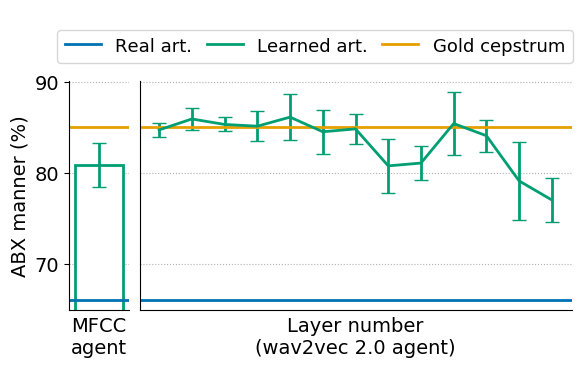

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
import math
import pandas as pd

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 14, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':2, 'errorbar.capsize': 5})

cepstrum_color = '#E69F00'
real_art_color = '#0072B2'
learned_art_color = '#009E73'

cm = 1/2.54
# Plot ABX place
fig = plt.figure(figsize=(14.5*cm,9.04*cm), constrained_layout=True)
gs = gridspec.GridSpec(2, 5, figure=fig, height_ratios=[1,10])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1:])
ax_legend = fig.add_subplot(gs[0, :])
ax_legend.axis('off')

# 1. (MFCC agent) Learned articulatory trajectories
key = 'manner_art_estimated'
Y = np.mean(baseline_cosine['mfcc_agent'][key])
Yerr = np.std(baseline_cosine['mfcc_agent'][key], ddof=1)
X = [0.5]
ax1.bar(X, Y, yerr=Yerr, linewidth=2, color='white', ecolor=learned_art_color, edgecolor=learned_art_color)

# 2. (MFCC agent) Real articulatory trajectories
key = 'manner_art'
Y = np.mean(gold_abx['gold'][key])
ax1.axhline(Y, color=real_art_color)

# 3. (MFCC agent) MFCCs
key = 'manner_mfcc'
Y = np.mean(gold_abx['gold'][key])
ax1.axhline(Y, color=cepstrum_color)

# 1. (wav2vec 2.0 agent) Learned articulatory trajectories
key = 'manner_art_estimated'
Y = [np.mean(w2v_cosine[f'ssl_agent_layer_{i}'][key]) for i in range(0,13)]
Yerr = [np.std(w2v_cosine[f'ssl_agent_layer_{i}'][key], ddof=1) for i in range(0,13)]
X = range(0, len(Y))
ax2.errorbar(X, Y, yerr=Yerr, color=learned_art_color)
ax2.set_xticks(X)

# 2. (wav2vec 2.0 agent) Real articulatory trajectories
key = 'manner_art'
Y = np.mean(gold_abx['gold'][key])
ax2.axhline(Y, color=real_art_color)

# 3. (wav2vec 2.0 agent) MFCCs
key = 'manner_mfcc'
Y = np.mean(gold_abx['gold'][key])
ax2.axhline(Y, color=cepstrum_color)
ax2.set_xticks([])

# Fashion
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(visible=True, axis='y', linestyle=':', zorder=0)
ax2.grid(visible=True, axis='y', linestyle=':', zorder=0)

ax1.set_xticks([])
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
ax1.set_ylim(ax2.get_ylim())
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax1.set_ylabel('ABX manner (%)')
ax2.set_xlabel('Layer number\n(wav2vec 2.0 agent)')
ax1.set_xlabel('MFCC\nagent')
ax1.set_xlim(0, 1)

legend_elements = [
    plt.Line2D([0], [0], color=real_art_color, lw=2, label='Real art.'),
    plt.Line2D([0], [0], color=learned_art_color, lw=2, label='Learned art.'),
    plt.Line2D([0], [0], color=cepstrum_color, lw=2, label='Gold cepstrum')
]

ax_legend.legend(handles=legend_elements, bbox_to_anchor=(1.02, 0.5), ncol=3, fontsize=13, columnspacing=.8)
plt.savefig('/home/engaclew/agent/out/ssl_agent/abx_manner_cosine.png', dpi=300)
plt.show()

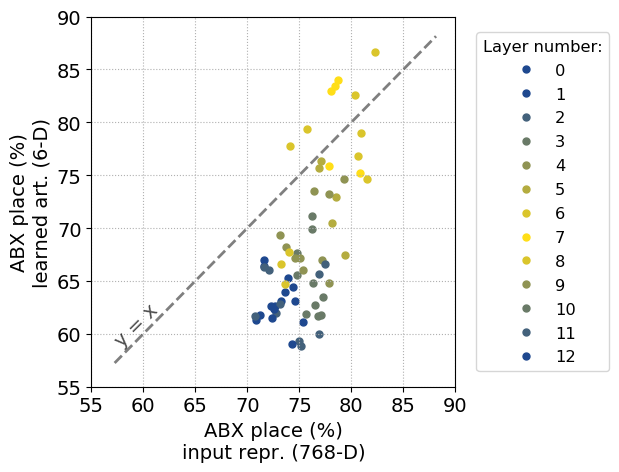

In [202]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler

def create_custom_colormap():
    # Define colors for start, middle, and end
    colors = ['#1E488F', '#FFDE17', '#1E488F']  # Dark blue, Bright yellow, Dark blue
    
    # Create custom colormap
    n_bins = 13  # Number of colors we need
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Generate color list
    color_list = [cmap(i) for i in np.concatenate([
        np.linspace(0, 0.5, 7, endpoint=False),  # First half, ending just before the middle
        np.linspace(0.5, 1, 6)  # Second half, starting from the middle
    ])]
    
    return color_list
    
fig= plt.figure(figsize=(16*cm,12*cm))
gs = GridSpec(1, 2, width_ratios=[3, 1], figure=fig)
ax = fig.add_subplot(gs[0, 0])

custom_colors = create_custom_colormap()
ax.set_prop_cycle(cycler(color=custom_colors))

for i in range(0, 13):
    ax.scatter(w2v_cosine[f'ssl_agent_layer_{i}']['place_feat_seq'], w2v_cosine[f'ssl_agent_layer_{i}']['place_art_estimated'], label=f'{i}')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
both_min = np.min([xmin,ymin])
both_max = np.max([xmax,ymax])
ax.set_xlim(both_min, both_max)
ax.set_ylim(both_min, both_max)

x = np.linspace(both_min, both_max, 100)
ax.plot(x, x, linestyle='--', color='black', alpha=.5)
ax.text(1.05*both_min-.7, 1.05*both_min+.7, 'y = x', rotation=45, ha='center', va='center', alpha=.7)
ax.set_xlabel('ABX place (%)\ninput repr. (768-D)')
ax.set_ylabel('ABX place (%)\nlearned art. (6-D)')

ticks = ax.get_yticks()
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.grid(visible=True, axis='both', linestyle=':', zorder=0)

legend_ax = fig.add_subplot(gs[0, 1])
legend_ax.axis('off')  # Turn off axis for legend subplot

# Add legend to the legend axis
handles, labels = ax.get_legend_handles_labels()
legend = legend_ax.legend(handles, labels, loc='center left', 
                          bbox_to_anchor=(-0.1, 0.5),  # Adjust this to move legend left/right
                          title='Layer number:', fontsize='small')

# Adjust legend title font size
legend.get_title().set_fontsize('small')

# Adjust layout
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
plt.savefig('/home/engaclew/agent/out/ssl_agent/abx_place_input_output.png', dpi=300)
plt.show()

In [2]:
# GAN analysis
agent_names = ['test_layer_6_cosine', 'test_layer_6_cosine_gan_0.01', 
               'test_layer_6_cosine_gan_0.1', 'test_layer_6_cosine_gan_1', 
               'test_layer_6_cosine_gan_10']

for agent_name in agent_names:
    agent_path = agent_folder / agent_name
    compute_ABX(agent_path)

# Load MSE
gan_cosine = []
for agent_name in agent_names:
    agent_path = agent_folder / agent_name / 'results' / 'test_ABX_pb2009.csv'
    res = pd.read_csv(agent_path).to_dict('list')
    res = {k:v[0] for k, v in res.items()}
    gan_cosine.append(res)

Already done


/home/engaclew/miniconda3/envs/agent/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Removing weight norm...


/home/engaclew/miniconda3/envs/agent/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Transposing features to get [T,N] vectors.
art_estimated
Transposing features to get [T,N] vectors.
feat_seq
Removing weight norm...
Transposing features to get [T,N] vectors.
art_estimated
Transposing features to get [T,N] vectors.
feat_seq
Removing weight norm...
Transposing features to get [T,N] vectors.
art_estimated
Transposing features to get [T,N] vectors.
feat_seq
Removing weight norm...
Transposing features to get [T,N] vectors.
art_estimated
Transposing features to get [T,N] vectors.
feat_seq


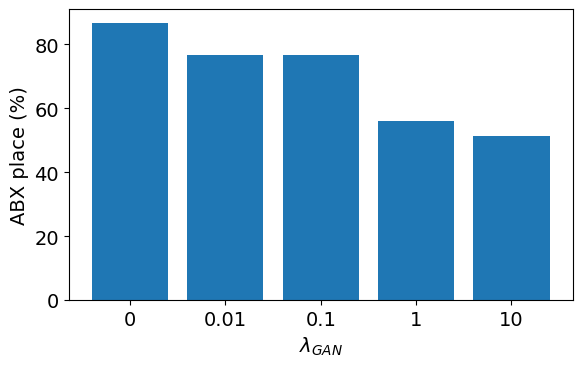

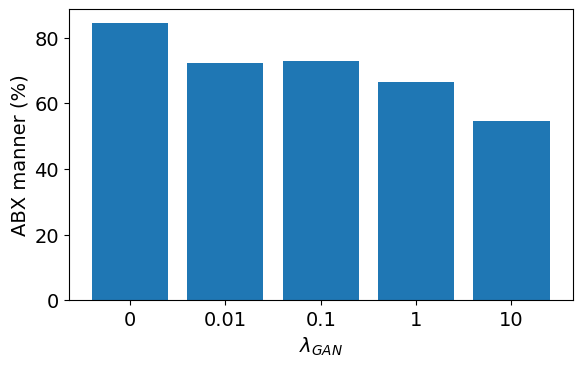

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import math
import pandas as pd

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 14, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':2})

cm = 1/2.54
# Plot ABX place
fig, ax = plt.subplots(1, 1, figsize=(14.5*cm,9.04*cm), constrained_layout=True)
weights = ['0', '0.01', '0.1', '1', '10']
key = 'place_art_estimated'
ax.bar(x=range(0, len(gan_cosine)), height=[agent[key] for agent in gan_cosine])
ax.set_xticks(range(0, len(gan_cosine)))
ax.set_xticklabels(weights)
ax.set_xlabel('$\lambda_{GAN}$')
ax.set_ylabel('ABX place (%)')
plt.savefig('/home/engaclew/agent/out/ssl_agent/abx_place_cosine_gan.png', dpi=300)
plt.show()

# Plot ABX manner
fig, ax = plt.subplots(1, 1, figsize=(14.5*cm,9.04*cm), constrained_layout=True)
weights = ['0', '0.01', '0.1', '1', '10']
key = 'manner_art_estimated'
ax.bar(x=range(0, len(gan_cosine)), height=[agent[key] for agent in gan_cosine])
ax.set_xticks(range(0, len(gan_cosine)))
ax.set_xticklabels(weights)
ax.set_xlabel('$\lambda_{GAN}$')
ax.set_ylabel('ABX manner (%)')
plt.savefig('/home/engaclew/agent/out/ssl_agent/abx_manner_cosine_gan.png', dpi=300)
plt.show()